In [1]:
# Load drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.listdir()

['.config', 'gdrive', 'sample_data']

In [3]:
import matplotlib.pyplot as plt

In [4]:
import json
key_file = open('/content/gdrive/MyDrive/MUStARD-master/data/sarcasm_data.json')
data = json.load(key_file)

key_order = list(data.keys())

In [5]:
# Load Individual Data

import pickle
import numpy as np

text_loc = "/content/gdrive/MyDrive/Pickle_Data/text_bert_embeddings.pkl"
audio_loc = "/content/gdrive/MyDrive/Pickle_Data/audio_features.pkl"
video_loc = "/content/gdrive/MyDrive/Pickle_Data/video_features.pkl"
label_map_loc = "/content/gdrive/MyDrive/Pickle_Data/label_map.pkl"

# Text features are available as numpy array in the key_order order
text_feats = pickle.load(open(text_loc, "rb"))

# Audio and Video Features are available as dict in random order - We pre-process them
audio_dict = pickle.load(open(audio_loc, "rb"))
video_dict = pickle.load(open(video_loc, "rb"))

# Label map: Key ---> Ground Truth Label
label_map = pickle.load(open(label_map_loc, "rb"))

# Final Extracted Features
audio_feats = []
video_feats = []

# Ground Truth Labels
y = []

for key in key_order:
  audio_feats.append(audio_dict[key])
  video_feats.append(video_dict[key])
  y.append(label_map[key])

text_feats = np.array(text_feats).astype('float32')
audio_feats = np.array(audio_feats).astype('float32')
video_feats = np.array(video_feats).astype('float32')
y = np.array(y).astype('float32')

In [ ]:
np.shape(text_feats), np.shape(audio_feats), np.shape(video_feats)

((690, 768), (690, 283), (690, 2048))

# Mean Difference Calculation

5% = 47  10% = 3


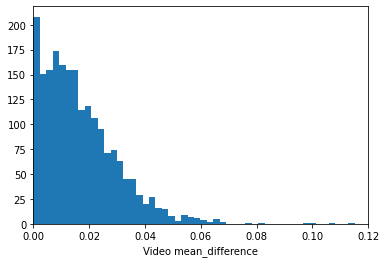

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

def find_changes(x, y_sarcasm, y_not_sarcasm):
  top_difference = []
  x = sc.fit_transform(x)
  for i in range(np.shape(x)[1]):
    f1_sarcasm = x[y_sarcasm, i]
    f1_not_sarcasm = x[y_not_sarcasm, i]
    top_difference.append((abs(np.mean(f1_sarcasm) - np.mean(f1_not_sarcasm))))
  
  print(f"5% = {np.sum(np.array(top_difference) > 0.05)}  10% = {np.sum(np.array(top_difference) > 0.1)}")
  plt.hist(top_difference, bins=50)
  plt.xlim(0,0.12)
  plt.xlabel('Video mean_difference')
  plt.show()

y_sarcasm = [i for i in range(len(y)) if y[i]==1]
y_not_sarcasm = [i for i in range(len(y)) if y[i]==0]

# find_changes(text_feats, y_sarcasm, y_not_sarcasm)
# find_changes(audio_feats, y_sarcasm, y_not_sarcasm)
find_changes(video_feats, y_sarcasm, y_not_sarcasm)

#EDA

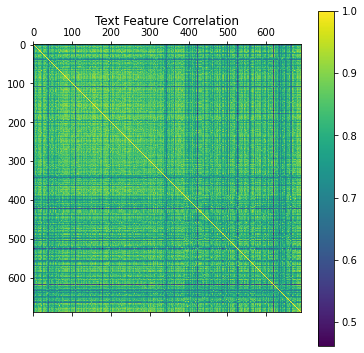

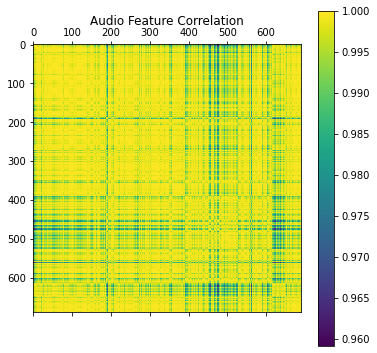

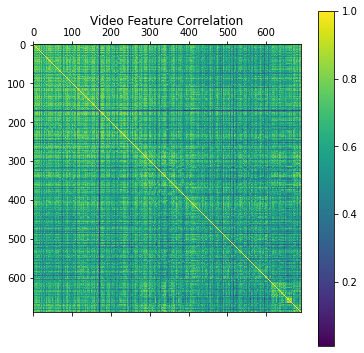

In [ ]:
text_corr = np.corrcoef(text_feats)

plt.figure(figsize=(6,6))
plt.matshow(text_corr, fignum=1)
plt.title('Text Feature Correlation')
plt.colorbar()
plt.show()

audio_corr = np.corrcoef(audio_feats)

plt.figure(figsize=(6,6))
plt.matshow(audio_corr, fignum=1)
plt.title('Audio Feature Correlation')
plt.colorbar()
plt.show()

video_corr = np.corrcoef(video_feats)

plt.figure(figsize=(6,6))
plt.matshow(video_corr, fignum=1)
plt.title('Video Feature Correlation')
plt.colorbar()
plt.show()

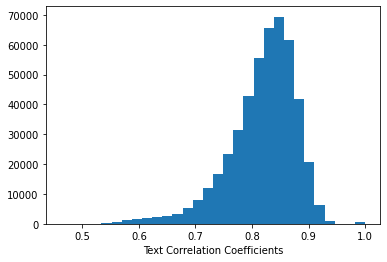

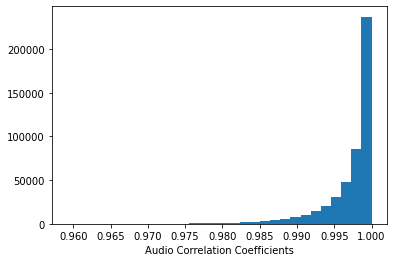

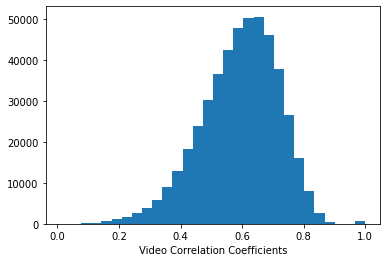

In [ ]:
plt.hist(np.reshape(text_corr, -1), bins=30)
plt.xlabel('Text Correlation Coefficients')
plt.show()

plt.hist(np.reshape(audio_corr, -1), bins=30)
plt.xlabel('Audio Correlation Coefficients')
plt.show()

plt.hist(np.reshape(video_corr, -1), bins=30)
plt.xlabel('Video Correlation Coefficients')
plt.show()


#Combined Analysis

In [59]:
# Concatenate all the modalities: Text - Audio - Video
X = np.concatenate([text_feats, audio_feats, video_feats], axis=1)
# X = np.concatenate([audio_feats], axis=1)

# Scale all the data values to 0-1 using min-max scalar
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Find sarcasm and not-sarcasm data indices (rows)
y_sarcasm = [i for i in range(len(y)) if y[i]==True]
y_not_sarcasm = [i for i in range(len(y)) if y[i]==False]

# Definition for computing histogram Overlap

def find_overlap(d1, d2):
  h1 = plt.hist(d1, bins=100)
  h2 = plt.hist(d2, bins=100)
  return np.sum(np.minimum(h1[0], h2[0]))

# Find the most important features: Using Max Drift
top_difference = []
for i in range(np.shape(X)[1]):
  f1_sarcasm = X[y_sarcasm, i]
  f1_not_sarcasm = X[y_not_sarcasm, i]
  top_difference.append((abs(np.mean(f1_sarcasm) - np.mean(f1_not_sarcasm))))
  # top_difference.append(find_overlap(f1_sarcasm, f1_not_sarcasm))

# Get the top 200 drifted features
max_drifted_features = np.argsort(top_difference)[::-1]
# max_drifted_features = np.argsort(top_difference)

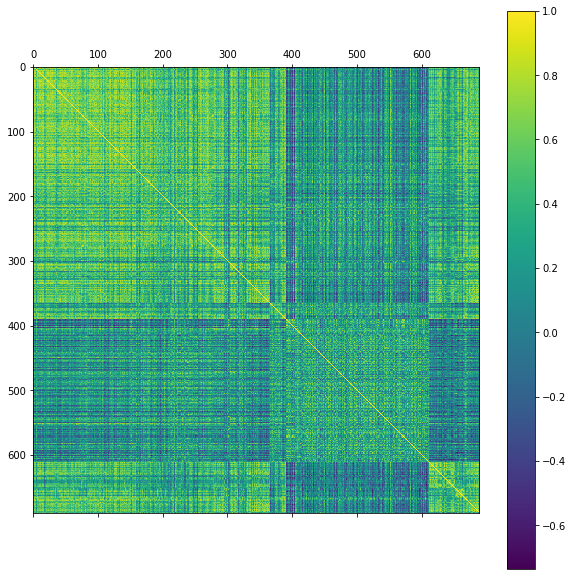

In [ ]:
# Correlation matrix for the top-k most drifted features
k = 25
top_k = X[:, max_drifted_features[0:k]]
top_k_cor = np.corrcoef(top_k)
plt.figure(figsize=(10,10))
plt.matshow(top_k_cor, fignum=1)
plt.colorbar()
plt.show()

In [ ]:
n_text = np.shape(text_feats)[1]
n_audio = np.shape(audio_feats)[1]
n_video = np.shape(video_feats)[1]

for i in range(20):
  cur_feat = max_drifted_features[i]
  if cur_feat < n_text:
    print(f"{i+1} Text_{cur_feat} {top_difference[cur_feat]}")
  elif cur_feat < n_text + n_audio:
    print(f"{i+1} Audio_{cur_feat - n_text} {top_difference[cur_feat]}")
  else:
    print(f"{i+1} Video_{cur_feat - n_text - n_audio} {top_difference[cur_feat]}")

# Feature Selection - Top Drifted

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold

clf = SVC()
# clf = GaussianNB()

test_score = []
select_num_feats = []
store_all = []

for r in range(0,10):
  
  X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.10, random_state=r)
  kf = KFold(n_splits = 5, shuffle = True, random_state = r)
  
  mean_score = []
  score = []

  for k in range(1,n_text,20):
  
    temp_score = []
  
    for train_index, test_index in kf.split(X_tv):
  
      X_train, y_train = X_tv[train_index], y_tv[train_index]
      X_val, y_val = X_tv[test_index], y_tv[test_index]
      y_pred = clf.fit(X_train[:,max_drifted_features[0:k]], y_train).predict(X_val[:,max_drifted_features[0:k]])
      temp_score.append(f1_score(y_val, y_pred))
  
    score.append(temp_score)
    mean_score.append(np.mean(temp_score))
  
  store_all.append(mean_score)
  num_features = np.argsort(mean_score)[-1] + 1
  select_num_feats.append(num_features)
  y_pred = clf.fit(X_tv[:, max_drifted_features[0:num_features]], y_tv).predict(X_test[:, max_drifted_features[0:num_features]])
  test_score.append(f1_score(y_test, y_pred))

NameError: ignored

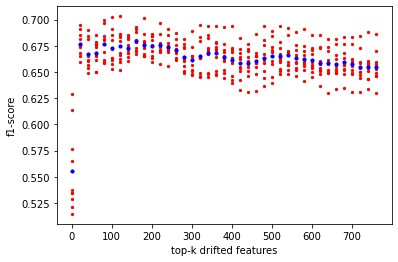

In [ ]:
for r in store_all:
  plt.scatter(np.arange(1,n_text,20), r, s=5, c='r', label='actual values')
plt.scatter(np.arange(1,n_text,20), np.mean(store_all, axis=0), s=10, c='b', label='mean values')
plt.xlabel('top-k drifted features')
plt.ylabel('f1-score')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

kf = KFold(n_splits = 10, shuffle = True, random_state = 0)
X = np.array(X)
k = 40
clf = SVC(probability=True)
# clf = GaussianNB()

temp_score_f1 = []
temp_score_acc = []
temp_score_pre = []
temp_score_rec = []
temp_score_auc = []


for train_index, test_index in kf.split(X):
  X_train, y_train = X[train_index], y[train_index]
  X_val, y_val = X[test_index], y[test_index]
  y_pred = clf.fit(X_train[:,max_drifted_features[0:k]], y_train).predict(X_val[:,max_drifted_features[0:k]])
  temp_score_f1.append(f1_score(y_val, y_pred))
  temp_score_acc.append(accuracy_score(y_val, y_pred))
  temp_score_pre.append(precision_score(y_val, y_pred))
  temp_score_rec.append(recall_score(y_val, y_pred))
  temp_score_auc.append(roc_auc_score(y_val, 1 - clf.fit(X_train[:,max_drifted_features[0:k]], y_train).predict_proba(X_val[:,max_drifted_features[0:k]])[:,0:1]))

print(f"F1 Score = {np.mean(temp_score_f1)} +- {np.std(temp_score_f1)}")
print(f"Accuracy Score = {np.mean(temp_score_acc)} +- {np.std(temp_score_acc)}")
print(f"Precision Score = {np.mean(temp_score_pre)} +- {np.std(temp_score_pre)}")
print(f"Recall Score = {np.mean(temp_score_rec)} +- {np.std(temp_score_rec)}")
print(f"ROC AUC Score = {np.mean(temp_score_auc)} +- {np.std(temp_score_auc)}")

F1 Score = 0.684563155886415 +- 0.06473610152373094
Accuracy Score = 0.6855072463768115 +- 0.0553956952278736
Precision Score = 0.6851021084498814 +- 0.0818429854475587
Recall Score = 0.6915590538594534 +- 0.08169350655523598
ROC AUC Score = 0.7471996258989178 +- 0.06347575020174887


In [ ]:
temp_score

0.8451178451178452

In [ ]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)
X = np.array(X)
k = 107

from sklearn.mixture import GaussianMixture
# clf = GaussianMixture(n_components=2)
clf = SVC()
# clf = GaussianNB()
temp_score = []

for train_index, test_index in kf.split(X):
  X_train, y_train = X[train_index], y[train_index]
  X_val, y_val = X[test_index], y[test_index]
  y_pred = clf.fit(X_train[:,max_drifted_features[0:k]], y_train).predict(X_val[:,max_drifted_features[0:k]])
  temp_score.append(f1_score(y_val, y_pred))
print(temp_score)
print(f"F1 Score = {np.mean(temp_score)} +- {np.std(temp_score)}")

NameError: ignored

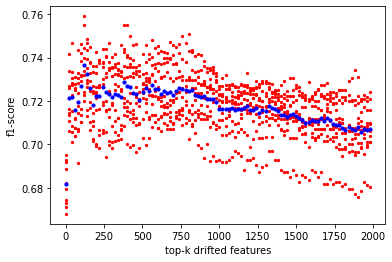

In [ ]:
for r in store_all:
  plt.scatter(np.arange(1,2000,20), r, s=5, c='r', label='actual values')
plt.scatter(np.arange(1,2000,20), np.mean(store_all, axis=0), s=10, c='b', label='mean values')
plt.xlabel('top-k drifted features')
plt.ylabel('f1-score')
plt.show()

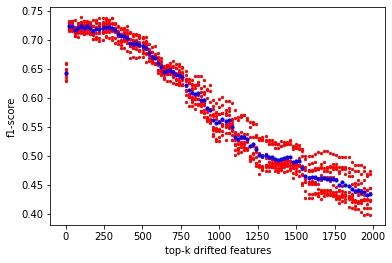

In [ ]:
for r in store_all:
  plt.scatter(np.arange(1,2000,20), r, s=5, c='r', label='actual values')
plt.scatter(np.arange(1,2000,20), np.mean(store_all, axis=0), s=10, c='b', label='mean values')
plt.xlabel('top-k drifted features')
plt.ylabel('f1-score')
plt.show()

# PCA Analysis

Total Accounted Variance = 77.11341977119446


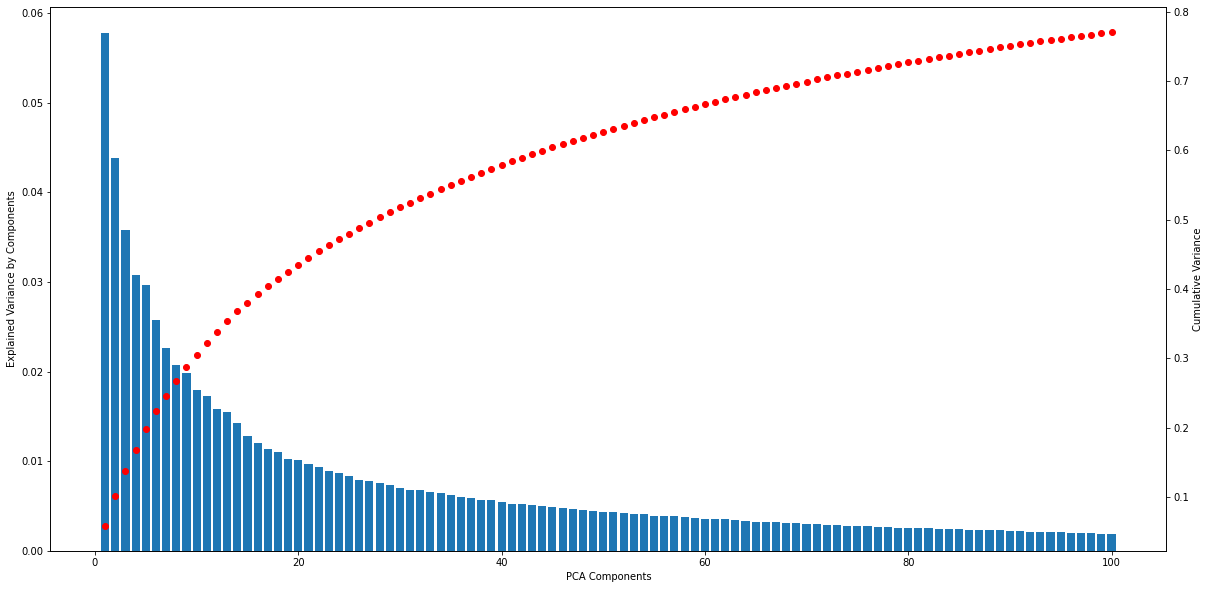

In [ ]:
from sklearn.decomposition import PCA
pca_components = 100
pca = PCA(n_components=pca_components)
X_d = pca.fit_transform(X)

pca_variance = pca.explained_variance_ratio_
cum_variance = []
sum = 0
for v in pca_variance:
  sum += v
  cum_variance.append(sum)

print(f"Total Accounted Variance = {np.sum(pca_variance)*100}")

fig,ax1 = plt.subplots()
fig.set_size_inches(20,10)
ax2 = ax1.twinx()
ax2.scatter(np.arange(1, pca_components+1), cum_variance, c='r')
ax2.set_ylabel('Cumulative Variance')
ax1.set_ylabel('Explained Variance by Components')
ax1.set_xlabel('PCA Components')
ax1.bar(np.arange(1,pca_components+1), pca_variance)
plt.show()

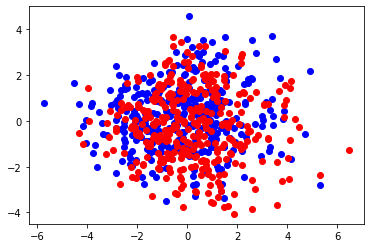

In [ ]:
plt.scatter(X_d[y_sarcasm, 0], X_d[y_sarcasm, 1], c='b')
plt.scatter(X_d[y_not_sarcasm, 0], X_d[y_not_sarcasm, 1], c='r')
plt.show()

In [ ]:
pca.components_[0,:]

array([-0.00250814,  0.00744458,  0.00124757, ...,  0.02846222,
        0.01054954,  0.01996218], dtype=float32)

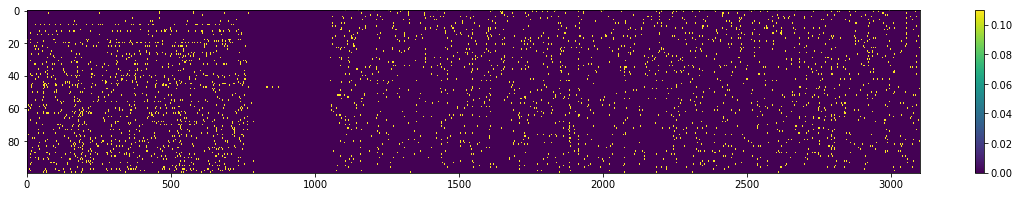

In [ ]:
f_contribution = abs(pca.components_) > 0.04
plt.figure(figsize=(20,3))
plt.imshow(f_contribution, interpolation='nearest', aspect='auto', vmax=0.11, vmin=0)
plt.colorbar()
plt.show()

In [ ]:
pc1 = [1, 2, 3, 0.1, 9, 99, 100, 0.4]
[100, 99, 9, 3, 2, 1, 0.4, 0.1]
100 - text_feat1
99 - text_feat2

In [ ]:
np.sum(f_contribution[:,0:n_text])/(pca_components * n_text), np.sum(f_contribution[:,n_text+1:n_text+n_audio])/(pca_components * n_audio), np.sum(f_contribution[:,n_text+n_audio+1:])/(pca_components * n_video) 

(0.0530078125, 0.001519434628975265, 0.030625)

In [ ]:
# Is there a relation between PCA and top_drifted features?

top_contributions = np.argsort(f_contribution, axis=1)
for r in top_contributions:
  print(list(set(r[0:100]) & (set(max_drifted_features[0:200]))))

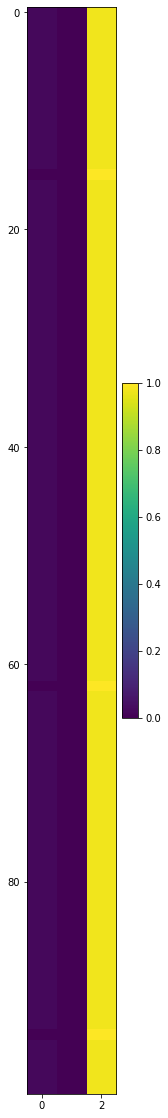

(array([ 1.94,  0.  , 98.06]), 100.0)

In [ ]:
# Text - Audio - Video Contribution to the PCA components

mod_contributions = []
n_com = 50
top_contributions = np.argsort(f_contribution, axis=1)[:,0:n_com]

n_text = np.shape(text_feats)[1]
n_audio = np.shape(audio_feats)[1]
n_video = np.shape(video_feats)[1]

for r in top_contributions:
  temp = []
  temp.append(np.sum(r < n_text))
  # print(temp[-1], np.sum(r < n_text + n_audio))
  temp.append(np.sum(r < n_text + n_audio) - temp[-1])
  temp.append(n_com - temp[-1] - temp[-2])
  mod_contributions.append(temp)

mod_contributions = np.array(mod_contributions)/n_com
# print(mod_contributions)
plt.figure(figsize=(2,20))
plt.imshow(mod_contributions, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

np.sum(mod_contributions, axis=0), np.sum(mod_contributions)

In [ ]:
# Text - Audio - Video Contribution to the PCA components

mod_contributions = []
n_com = 1
top_contributions = np.argsort(f_contribution, axis=1)

n_text = np.shape(text_feats)[1]
n_audio = np.shape(audio_feats)[1]
n_video = np.shape(video_feats)[1]

ind_cont = []
for i in range(0,100):
  r = top_contributions[i,0:200]
  temp = []
  temp.append(np.sum(r < n_text))
  temp.append(np.sum(r < n_text + n_audio) - temp[-1])
  temp.append(200 - temp[-1] - temp[-2])
  ind_cont.append(temp)

ind_cont

[[1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [0, 0, 200],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [0, 0, 200],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0, 199],
 [1, 0

# Feature Reduction - PCA

Total Accounted Variance = 99.99833106994629


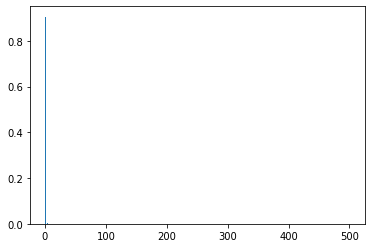

In [60]:
# PCA Application on the most drifted features

# X_d = X[:, max_drifted_features]
X_d = X

from sklearn.decomposition import PCA
pca_components = 500
pca = PCA(n_components=pca_components)
X_d = pca.fit_transform(X_d)

pca_variance = pca.explained_variance_ratio_
print(f"Total Accounted Variance = {np.sum(pca_variance)*100}")
plt.bar(np.arange(1,pca_components+1), pca_variance)
plt.show()


# Analysing the performance of PCA feature reduction

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold

clf = SVC()
# clf = GaussianNB()

test_score = []
store_all = []

for r in range(0,10):
  
  X_tv, X_test, y_tv, y_test = train_test_split(X_d, y, test_size=0.10, random_state=r)
  kf = KFold(n_splits = 5, shuffle = True, random_state = r)
  
  mean_score = []
  score = []

  for k in range(1,pca_components,10):
  
    temp_score = []
  
    for train_index, test_index in kf.split(X_tv):
  
      X_train, y_train = X_tv[train_index], y_tv[train_index]
      X_val, y_val = X_tv[test_index], y_tv[test_index]
      y_pred = clf.fit(X_train[:,0:k], y_train).predict(X_val[:,0:k])
      temp_score.append(f1_score(y_val, y_pred))
  
    score.append(temp_score)
    mean_score.append(np.mean(temp_score))
  store_all.append(mean_score)
  num_features = np.argsort(mean_score)[-1] + 1
  y_pred = clf.fit(X_tv[:, 0:k], y_tv).predict(X_test[:, 0:k])
  test_score.append(f1_score(y_test, y_pred))

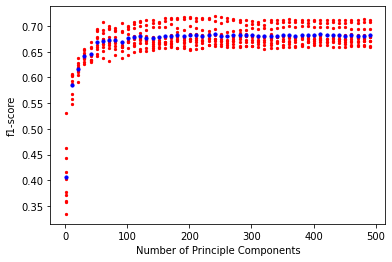

In [ ]:
plt.rcParams['axes.facecolor'] = 'white'
for r in store_all:
  plt.scatter(np.arange(1,500,10), r, s=5, c='r', label='actual values')
plt.scatter(np.arange(1,500,10), np.mean(store_all, axis=0), s=10, c='b', label='mean values')
plt.xlabel('Number of Principle Components')
plt.ylabel('f1-score')
plt.show()

In [ ]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

from sklearn.decomposition import PCA
pca_components = 100
pca = PCA(n_components=pca_components)
X_d = pca.fit_transform(X)

X = np.array(X_d)
k = 100
clf = SVC(probability=True)
# clf = GaussianNB()
temp_score_f1 = []
temp_score_acc = []
temp_score_pre = []
temp_score_rec = []
temp_score_auc = []


for train_index, test_index in kf.split(X):
  X_train, y_train = X[train_index], y[train_index]
  X_val, y_val = X[test_index], y[test_index]
  y_pred = clf.fit(X_train[:,0:k], y_train).predict(X_val[:,0:k])

  temp_score_f1.append(f1_score(y_val, y_pred))
  temp_score_acc.append(accuracy_score(y_val, y_pred))
  temp_score_pre.append(precision_score(y_val, y_pred))
  temp_score_rec.append(recall_score(y_val, y_pred))
  temp_score_auc.append(roc_auc_score(y_val, 1 - clf.fit(X_train[:,0:k], y_train).predict_proba(X_val[:,0:k])[:,0:1]))

print(f"F1 Score = {np.mean(temp_score_f1)} +- {np.std(temp_score_f1)}")
print(f"Accuracy Score = {np.mean(temp_score_acc)} +- {np.std(temp_score_acc)}")
print(f"Precision Score = {np.mean(temp_score_pre)} +- {np.std(temp_score_pre)}")
print(f"Recall Score = {np.mean(temp_score_rec)} +- {np.std(temp_score_rec)}")
print(f"ROC AUC Score = {np.mean(temp_score_auc)} +- {np.std(temp_score_auc)}")

F1 Score = 0.6852032952641276 +- 0.03441039336410481
Accuracy Score = 0.673913043478261 +- 0.03383367399979351
Precision Score = 0.6634315471911859 +- 0.06599297544161183
Recall Score = 0.7148451982073037 +- 0.037603125760643695
ROC AUC Score = 0.7397259739845313 +- 0.03564042340133735


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

kf = KFold(n_splits = 10, shuffle = True, random_state = 0)
X = np.array(X)
k = 107
clf = SVC()
# clf = GaussianNB()

temp_score_f1 = []
temp_score_acc = []
temp_score_pre = []
temp_score_rec = []


for train_index, test_index in kf.split(X):
  X_train, y_train = X[train_index], y[train_index]
  X_val, y_val = X[test_index], y[test_index]
  y_pred = clf.fit(X_train[:,max_drifted_features[0:k]], y_train).predict(X_val[:,max_drifted_features[0:k]])
  
  temp_score_f1.append(f1_score(y_val, y_pred))
  temp_score_acc.append(accuracy_score(y_val, y_pred))
  temp_score_pre.append(precision_score(y_val, y_pred))
  temp_score_rec.append(recall_score(y_val, y_pred))

print(f"F1 Score = {np.mean(temp_score_f1)} +- {np.std(temp_score_f1)}")
print(f"Accuracy Score = {np.mean(temp_score_acc)} +- {np.std(temp_score_acc)}")
print(f"Precision Score = {np.mean(temp_score_pre)} +- {np.std(temp_score_pre)}")
print(f"Recall Score = {np.mean(temp_score_rec)} +- {np.std(temp_score_rec)}")

# Unsupervised 

In [61]:
# Concatenate all the modalities: Text - Audio - Video
X = np.concatenate([text_feats, audio_feats, video_feats], axis=1)

# Scale all the data values to 0-1 using min-max scalar
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Total Accounted Variance = 98.73759746551514


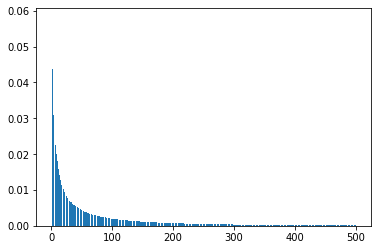

In [62]:
X_d = X

from sklearn.decomposition import PCA
pca_components = 500
pca = PCA(n_components=pca_components)
X_d = pca.fit_transform(X_d)

pca_variance = pca.explained_variance_ratio_
print(f"Total Accounted Variance = {np.sum(pca_variance)*100}")
plt.bar(np.arange(1,pca_components+1), pca_variance)
plt.show()

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

gmm_accuracy = []
gmm_accuracy_mean = []
num_feats = []

for k in range(1,500,10):

  temp_accuracy = []
  num_feats.append(k)

  for l in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X[:,0:k], y, test_size=0.15, random_state=l)

    gmm = GaussianMixture(n_components = 2, max_iter = 100, init_params = 'kmeans', warm_start=False)
    # gmm = KMeans(n_clusters=2, init='k-means++')
    gmm.fit(X_train)
    y_pred = gmm.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    if(cm[0,0] + cm[1,1] > cm[1,0] + cm[0,1]):
      temp_accuracy.append((cm[0,0] + cm[1,1])/len(y_pred))
    else:
      temp_accuracy.append((cm[1,0] + cm[0,1])/len(y_pred))
  
  gmm_accuracy.append(temp_accuracy)
  gmm_accuracy_mean.append(np.mean(temp_accuracy))


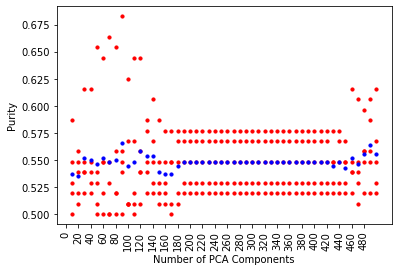

In [67]:
# plt.figure(figsize=(10,8))
# plt.ylim(0.5,0.8)
for i, r in enumerate(gmm_accuracy):
  plt.scatter((i+1) * np.ones(len(r)), r, s=10, c='r')
plt.scatter(np.arange(1,len(gmm_accuracy_mean)+1), gmm_accuracy_mean, c='b', s=10)
plt.xticks(np.arange(0,len(gmm_accuracy_mean),2), np.array(num_feats)[::2]-1, rotation=90)
plt.ylabel('Purity')
plt.xlabel('Number of PCA Components')
plt.show()

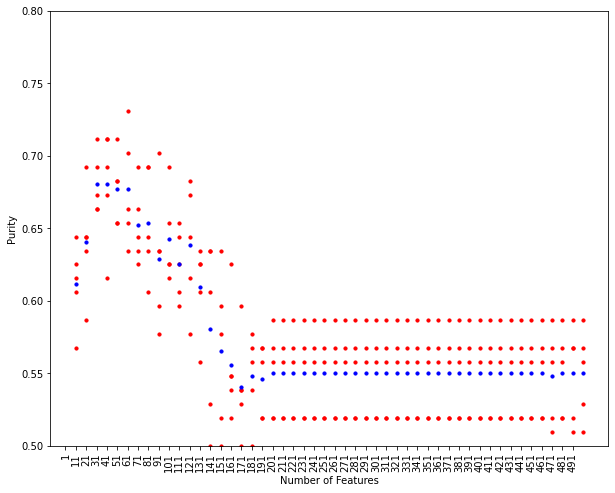

In [ ]:
plt.figure(figsize=(10,8))
plt.ylim(0.5,0.8)
for i, r in enumerate(gmm_accuracy):
  plt.scatter((i+1) * np.ones(len(r)), r, s=10, c='r')
plt.scatter(np.arange(1,len(gmm_accuracy_mean)+1), gmm_accuracy_mean, c='b', s=10)
plt.xticks(np.arange(len(gmm_accuracy_mean)), num_feats, rotation=90)
plt.ylabel('Purity')
plt.xlabel('Number of Features')
plt.show()

In [68]:
pre = []
rec = []
f1 = []
fm = []
jac = []
ran = []
nmi = []
for i in range(10):
  X_train, X_test, y_train, y_test = train_test_split(X[:,0:70], y, test_size=0.10, random_state=i)
  # gmm = KMeans(n_clusters=2, init='k-means++')
  gmm = GaussianMixture(n_components = 2, max_iter = 100, init_params = 'kmeans', warm_start=False)
  gmm.fit(X_train)
  y_pred = gmm.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  x1, x2, _, x3, p, c, t = matching_score(cm)
  x4, n = nmi_fn(p, c, t)
  x5, x6, x7 = pairwise_measure(p, n)
  pre.append(x1)
  rec.append(x2)
  f1.append(x3)
  nmi.append(x4)
  jac.append(x5)
  ran.append(x6)
  fm.append(x7)

print(f"Precision = {round(np.mean(pre),3)} +- {round(np.std(pre),3)}")
print(f"Recall = {round(np.mean(rec),3)} +- {round(np.std(rec),3)}")
print(f"F1 = {round(np.mean(f1),3)} +- {round(np.std(f1),3)}")
print(f"NMI = {round(np.mean(nmi),3)} +- {round(np.std(nmi),3)}")
print(f"Jac = {round(np.mean(jac),3)} +- {round(np.std(jac),3)}")
print(f"Rand = {round(np.mean(ran),3)} +- {round(np.std(ran),3)}")
print(f"Fm = {round(np.mean(fm),3)} +- {round(np.std(fm),3)}")


Precision = 0.701 +- 0.239
Recall = 0.606 +- 0.122
F1 = 0.522 +- 0.037
NMI = 0.024 +- 0.019
Jac = 0.398 +- 0.024
Rand = 0.504 +- 0.014
Fm = 0.575 +- 0.028


In [30]:
# Matching Based Scores

# Get the clustering values from the confusion matrix
def matching_score(cm):
  if(cm[0,0] + cm[1,1] > cm[1,0] + cm[0,1]):
    p00 = cm[0,0]
    p01 = cm[0,1]
    p10 = cm[1,0]
    p11 = cm[1,1]
  else:
    p00 = cm[0,1]
    p01 = cm[0,0]
    p10 = cm[1,1]
    p11 = cm[1,0]

  p = [[p00, p01], [p10, p11]]

  c0 = p[0][0] + p[0][1]
  c1 = p[1][0] + p[1][1]

  c = [c0, c1]

  t0 = p[0][0] + p[1][0]
  t1 = p[0][1] + p[1][1]

  t = [t0, t1]

  # Computing precision, recall and f-measure

  precision = [p[0][0]/c[0], p[1][1]/c[1]]
  recall = [p[0][0]/t[0], p[1][1]/t[1]]

  f_measure = []
  for i in range(2):
    d = 1/precision[i] + 1/recall[i]
    f_measure.append(2/d)

  f_score = np.mean(f_measure)
  return precision[1], recall[1], f_measure[1], f_score, p, c, t

In [28]:
# Entropy based Scores - Normalized Mutual Information

def nmi_fn(p, c, t):
  mutual_info = 0
  n = len(y_test)

  for i in range(2):
    for j in range(2):
      mutual_info += p[i][j]/n * np.log(p[i][j] * n /(c[i] * t[j]))

  entropy_c = 0

  for i in range(2):
    prob_i = c[i]/n
    entropy_c += -1 * prob_i * np.log(prob_i)

  entropy_t = 0

  for i in range(2):
    prob_i = t[i]/n
    entropy_t += -1 * prob_i * np.log(prob_i)

  normalized_mutual_info = mutual_info/(entropy_c * entropy_t)**0.5
  return normalized_mutual_info, n

In [27]:
# Pairwise distance score

def pairwise_measure(p, n):
  tp = 0
  fn = 0
  fp = 0
  tn = 0

  for i in range(2):
    for j in range(2):
      tp += p[i][j]*p[i][j]

  tp = 0.5 * (tp - n)

  for i in range(2):
    fp += 0.5 * c[i] * (c[i] - 1)

  fp -= tp

  for j in range(2):
    fn += 0.5 * t[j] * (t[j] - 1)

  fn -= tp

  N = 0.5 * n * (n-1)
  tn = N - tp - fn - fp

  jaccard = tp/(tp + fn + fp)
  rand = (tp + tn)/N

  prec = tp/(tp + fp)
  recall = tp/(tp + fn)

  fm_measure = (prec * recall)**0.5

  return jaccard, rand, fm_measure

## Trying DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from collections import Counter

direct = []
dbscan = []

for k in np.arange(0.1, 1.0, 0.1):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k)

  gmm = DBSCAN(eps=10, min_samples=10)
  y_pred = gmm.fit_predict(X_train)
  y_pred, accuracy_score(y_train, y_pred)
  selected_rows = [i for i in range(len(X_train)) if y_pred[i]==0]

  gmm = GaussianMixture(n_components = 2, max_iter = 100, init_params = 'kmeans', warm_start=False)
  gmm.fit(X_train[selected_rows, :][:, max_drifted_features[0:50]])
  y_pred = gmm.predict(X_test[:, max_drifted_features[0:50]])
  cm = confusion_matrix(y_test, y_pred)

  p = np.trace(cm)/len(y_test)
  if p>0.5:
    dbscan.append(p)
  else:
    dbscan.append(1-p)

  gmm = GaussianMixture(n_components = 2, max_iter = 100, init_params = 'kmeans', warm_start=False)
  gmm.fit(X_train[:, max_drifted_features[0:50]])
  y_pred = gmm.predict(X_test[:, max_drifted_features[0:50]])
  cm = confusion_matrix(y_test, y_pred)

  p = np.trace(cm)/len(y_test)
  if p>0.5:
    direct.append(p)
  else:
    direct.append(1-p)

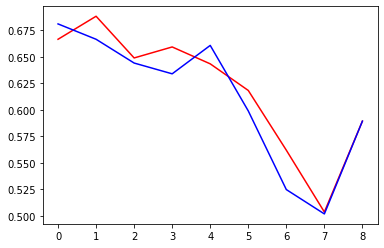

In [ ]:
plt.plot(np.arange(len(direct)), direct, c='r')
plt.plot(np.arange(len(direct)), dbscan, c='b')
plt.show()

In [ ]:
gmm = GaussianMixture(n_components = 2, max_iter = 100, init_params = 'kmeans', warm_start=False)
gmm.fit(X_train[selected_rows, :][:, max_drifted_features[0:50]])
y_pred = gmm.predict(X_test[:, max_drifted_features[0:50]])
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 76,  96],
       [ 27, 146]])

In [ ]:
gmm = GaussianMixture(n_components = 2, max_iter = 100, init_params = 'kmeans', warm_start=False)
gmm.fit(X_train[:, max_drifted_features[0:50]])
y_pred = gmm.predict(X_test[:, max_drifted_features[0:50]])
cm = confusion_matrix(y_test, y_pred)
cm

array([[101,  71],
       [149,  24]])